# 
https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=cc57b01f

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch

from ddpm import LatentDiffusionModel, CustomDataset, get_ddpm_scheduler_variables, extract
from tqdm.auto import tqdm

timesteps = 1000
timesteps, betas, alphas, alphas_cumprod, alphas_cumprod_prev, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance = get_ddpm_scheduler_variables(timesteps=timesteps)

device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 初始化模型
latent_dim = 256
hidden_dims = [2048, 2048, 2048, 2048] 
# hidden_dims = [1024, 1024, 1024, 1024] 
max_freq = 4  # Example max frequency for Fourier features
num_bands = 4  # Number of frequency bands
scalar_hidden_dims = [256,256,256,256]
diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims, scalar_hidden_dims, max_freq, num_bands).to(device)
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_20k_test1/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_20k_l2loss/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_30k_l1huber_normT/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_30k_l2_normT/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/NEWmugs_ddpm_cos_10k_l1huber/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_30k_l1huber_normT_1024/model.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_100k_l1huber_normT_2048_steps10k/model.pth"

# 12-31
diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/mugs_ddpm_cos_200k_l1huber_normT_2048_dataNorm/model_epo199999.pth"
diffusion_ckpt = torch.load(diffusion_ckpt_path, map_location=device)
diffusion_model.load_state_dict(diffusion_ckpt['model'])
diffusion_model = diffusion_model.to(device)
print('Diffusion Model parameters:', sum(p.numel() for p in diffusion_model.parameters()))

Using device: cuda:6
Diffusion Model parameters: 51956544


In [2]:
time_value = 999
t = torch.tensor([time_value]*3)
tensor = torch.tensor([10]*3)
extract(posterior_variance, t, tensor)

tensor([[[0.0200]],

        [[0.0200]],

        [[0.0200]]])

In [3]:
sqrt_alphas_cumprod[0:100]

tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996, 0.9994, 0.9993, 0.9992,
        0.9991, 0.9989, 0.9987, 0.9986, 0.9984, 0.9982, 0.9980, 0.9978, 0.9976,
        0.9973, 0.9971, 0.9969, 0.9966, 0.9963, 0.9961, 0.9958, 0.9955, 0.9952,
        0.9948, 0.9945, 0.9942, 0.9938, 0.9935, 0.9931, 0.9927, 0.9924, 0.9920,
        0.9916, 0.9911, 0.9907, 0.9903, 0.9898, 0.9894, 0.9889, 0.9884, 0.9880,
        0.9875, 0.9870, 0.9865, 0.9859, 0.9854, 0.9849, 0.9843, 0.9838, 0.9832,
        0.9826, 0.9820, 0.9814, 0.9808, 0.9802, 0.9796, 0.9789, 0.9783, 0.9776,
        0.9770, 0.9763, 0.9756, 0.9749, 0.9742, 0.9735, 0.9728, 0.9721, 0.9713,
        0.9706, 0.9698, 0.9691, 0.9683, 0.9675, 0.9667, 0.9659, 0.9651, 0.9643,
        0.9635, 0.9626, 0.9618, 0.9610, 0.9601, 0.9592, 0.9583, 0.9575, 0.9566,
        0.9556, 0.9547, 0.9538, 0.9529, 0.9519, 0.9510, 0.9500, 0.9491, 0.9481,
        0.9471])

In [11]:
pred_x_0_list = []
@torch.no_grad()
def uncond_p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    # Note: \grad_{x_t} \log p(x_t|x_0) = - (\epsilon) / (\sqrt{1 - \alpha^{hat}_t})
    #                                   = - model(x, t) / sqrt_one_minus_alphas_cumprod_t
    model_out = model(x, t, timesteps)

    score_x = model_out / sqrt_one_minus_alphas_cumprod_t
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * score_x
    )
    # if t[0]>1:
    #     sqrt_alphas_cumprod_tminus1 = extract(sqrt_alphas_cumprod, t-1, x.shape)
    # else:
    #     sqrt_alphas_cumprod_tminus1 = torch.ones_like(x)
    # pred_x_0 = sqrt_recip_alphas_t * (x - sqrt_one_minus_alphas_cumprod_t * model_out) / sqrt_alphas_cumprod_tminus1
    
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x.shape)
    pred_x_0 = (x - sqrt_one_minus_alphas_cumprod_t * model_out) / sqrt_alphas_cumprod_t
    pred_x_0_list.append(pred_x_0)
    
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
        
# Algorithm 2:
@torch.no_grad()
def uncond_p_sample_loop(model, shape, return_traj = False):
    # assert eta in [0, 1]
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    x_t = torch.randn(shape, device=device)
    traj = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        x_t_minus1 = uncond_p_sample(model, x_t, torch.full((b,), i, device=device, dtype=torch.long), i)
        x_t = x_t_minus1
        traj.append(x_t.cpu())
    if return_traj:
        return torch.stack(traj, dim=1)
    else:    
        return x_t

torch.manual_seed(12)
bs = 5
eta = 1.
trajs = uncond_p_sample_loop(model=diffusion_model, shape=(bs, 256, 4), return_traj=True)

In [6]:

from init import get_AEmodel_cfg
from core.models import get_model
category = "mugs"
# category = "kit4cates"
# category = "chairs"
config_Only_model = get_AEmodel_cfg()
ModelClass = get_model(config_Only_model["model"]["model_name"])
model = ModelClass(config_Only_model)
ckpt_path = f"/home/ziran/se3/EFEM/weights/{category}.pt"
# ckpt_path = f"/home/ziran/se3/EFEM/lib_shape_prior/log/12_10_shape_prior_mugs_old/12_10_shape_prior_mugs_FOR_hopefullybetterAE/checkpoint/15409.pt"
ckpt = torch.load(ckpt_path, map_location=device)
model.network.load_state_dict(ckpt['model_state_dict'])
model.network = model.network.to(device)


In [7]:
len(pred_x_0_list)

# pred_x_0_list[0].shape

1000

In [14]:
codebook_path = f"/home/ziran/se3/EFEM/cache/mugs.npz"
train_ds = CustomDataset(codebook_path, normalization = True)

z_so3 (149, 256, 3)
z_inv (149, 256)
center (149, 1, 3)
scale (149,)
z_so3_proj (149, 256, 3)
z_so3_basis (149, 3, 3)
z_so3_var (149, 3)
bbox (149, 3)
bbox_c (149, 3)
pcl (149, 5000, 3)
cls (149,)
========== Data Normalization BEGIN ==========
z_so3_mean tensor(0.0039)
z_so3_std tensor(0.0359)
z_inv_mean tensor(-0.0006)
z_inv_std tensor(0.0132)
========== Data Normalization FINISHED ==========


## Traj over time(predicted x_0)

use normal params: {'z_so3_mean': tensor(0.0039), 'z_so3_std': tensor(0.0359), 'z_inv_mean': tensor(-0.0006), 'z_inv_std': tensor(0.0132)}
shape:  torch.Size([10, 256, 3]) torch.Size([10, 256]) torch.Size([10]) torch.Size([10, 1, 3])
rows: 4 cols: 3


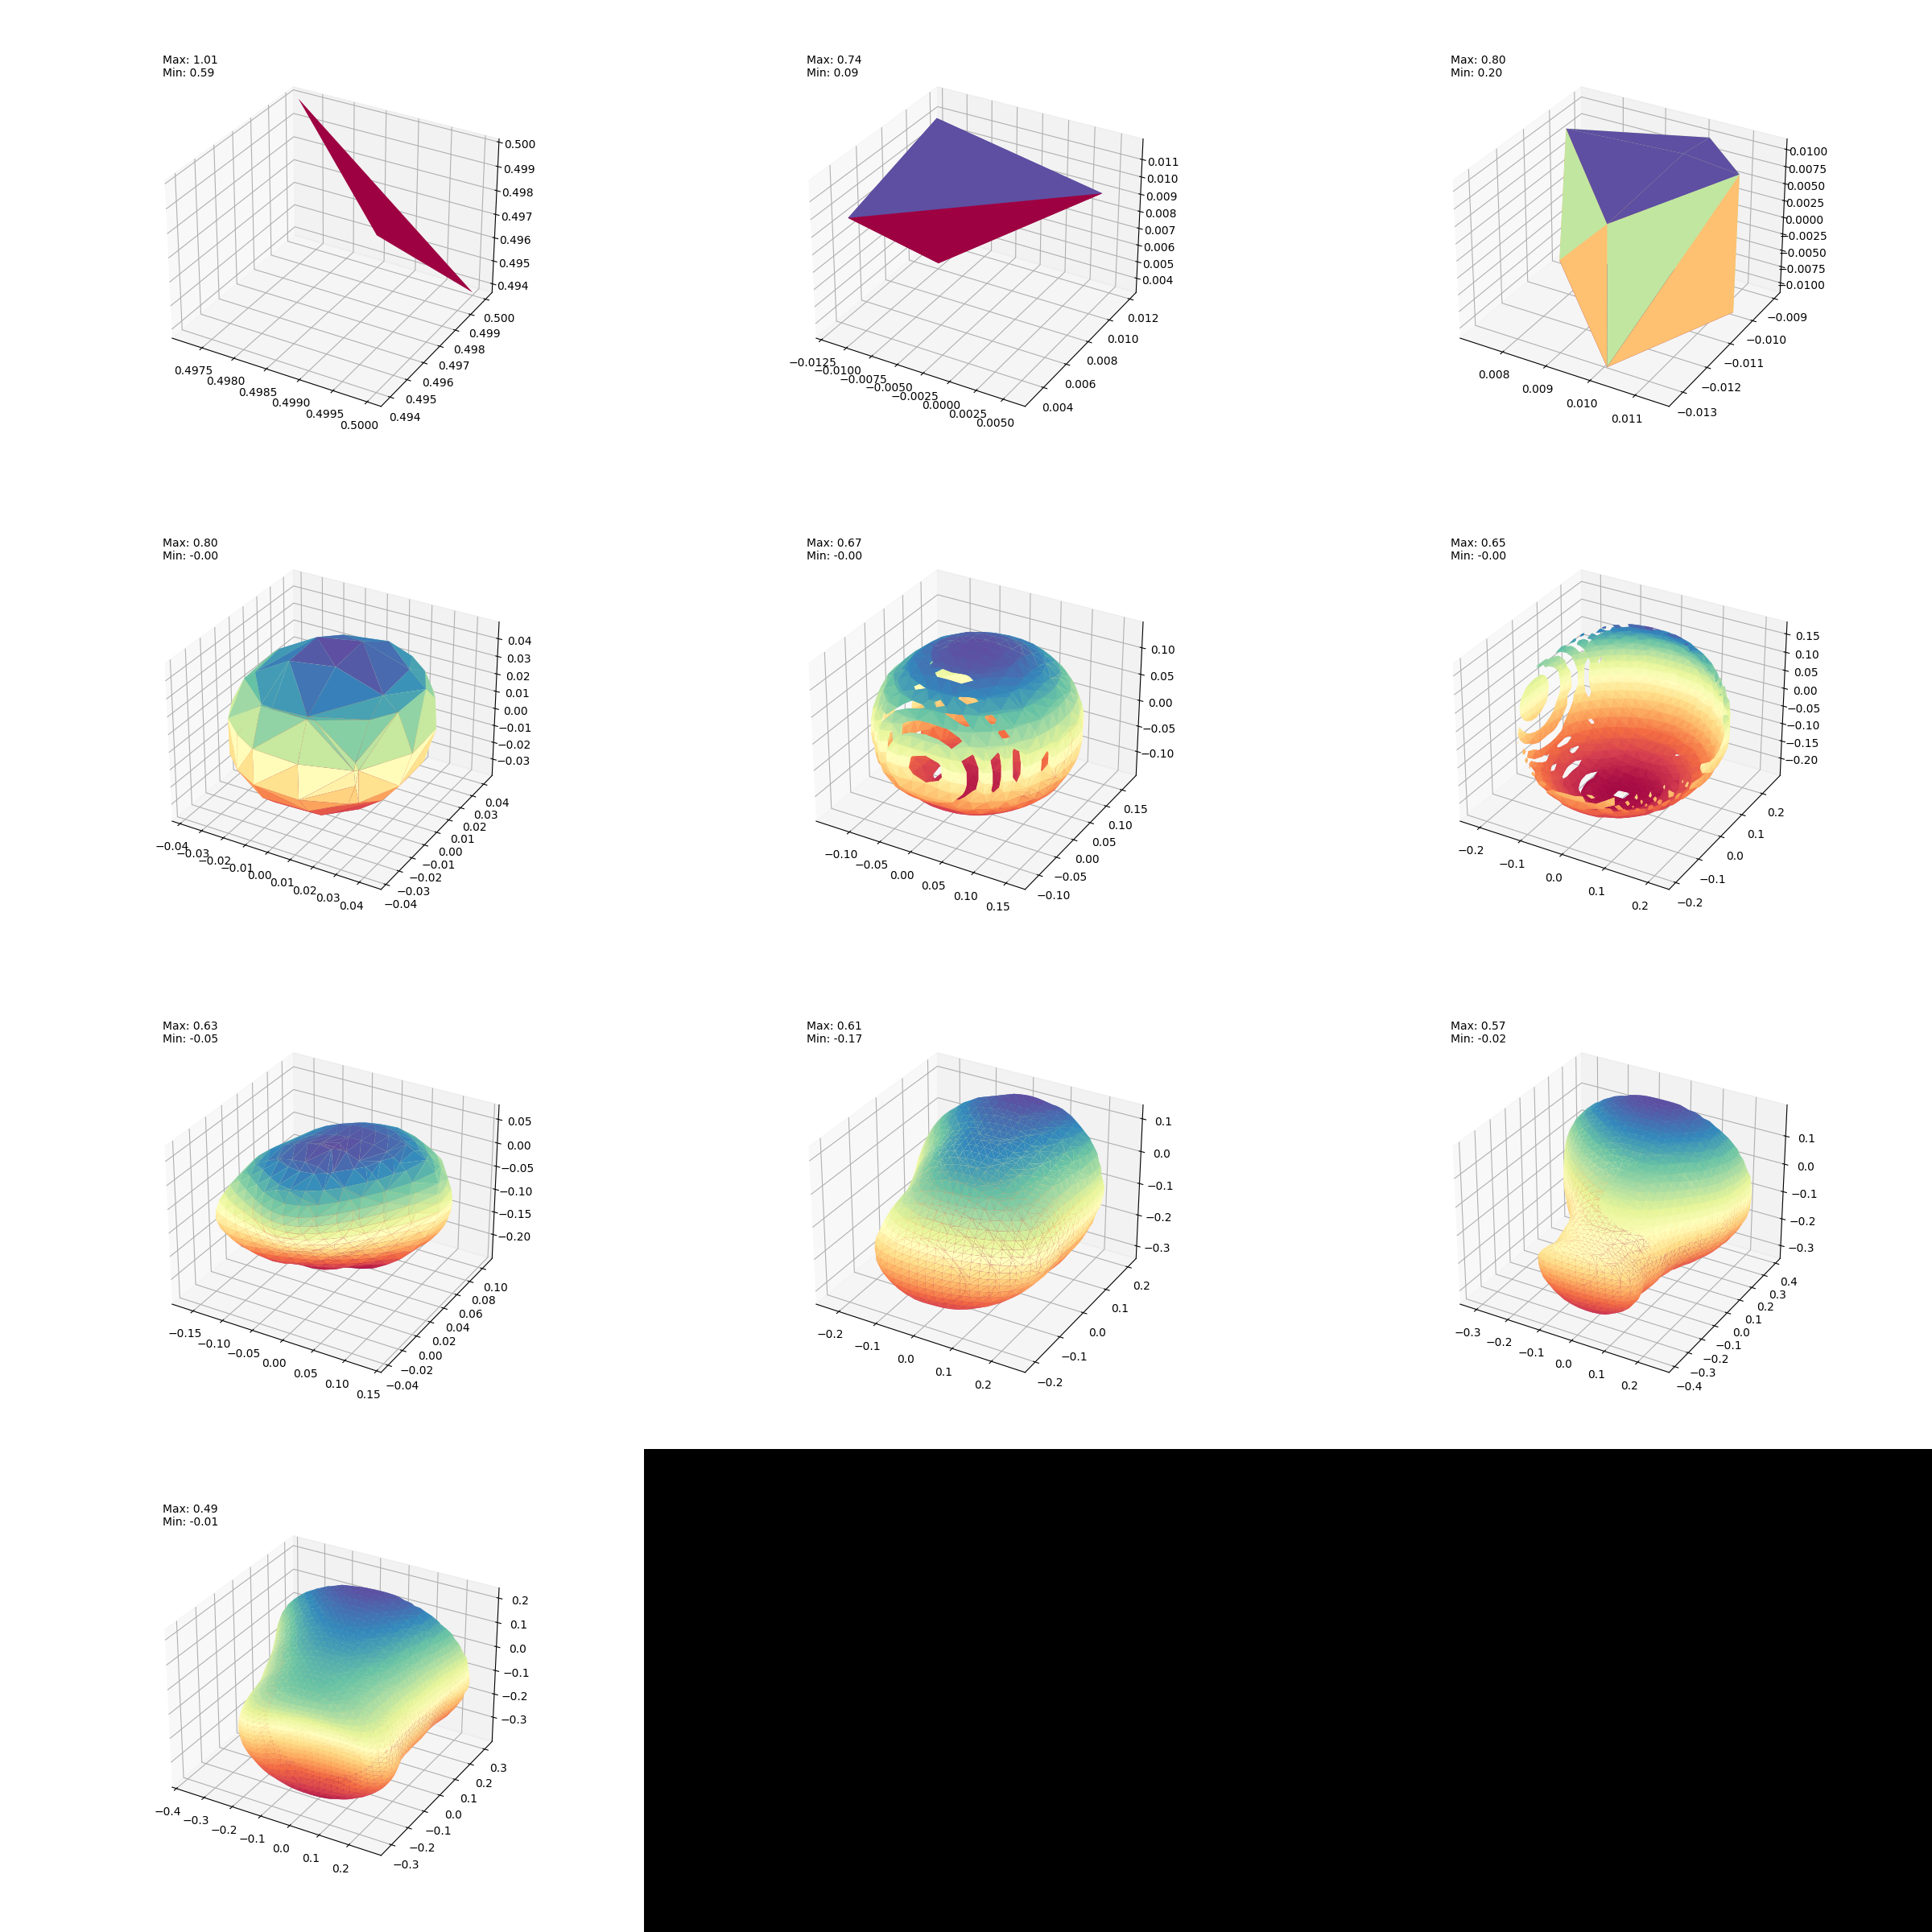

In [18]:
from viz_x import viz_x_img
img_list, img = viz_x_img(trajs[2,0:1001:100],model, device, train_ds.normal_params)
display(img)

In [19]:

time_slice = slice(1, 1001, 50)
print(time_slice)
sample_idx = 2
a = torch.stack([item[sample_idx] for item in pred_x_0_list[time_slice]], dim=0)
a.shape


slice(1, 1001, 50)


torch.Size([20, 256, 4])

use normal params: {'z_so3_mean': tensor(0.0039), 'z_so3_std': tensor(0.0359), 'z_inv_mean': tensor(-0.0006), 'z_inv_std': tensor(0.0132)}
shape:  torch.Size([20, 256, 3]) torch.Size([20, 256]) torch.Size([20]) torch.Size([20, 1, 3])
rows: 4 cols: 5


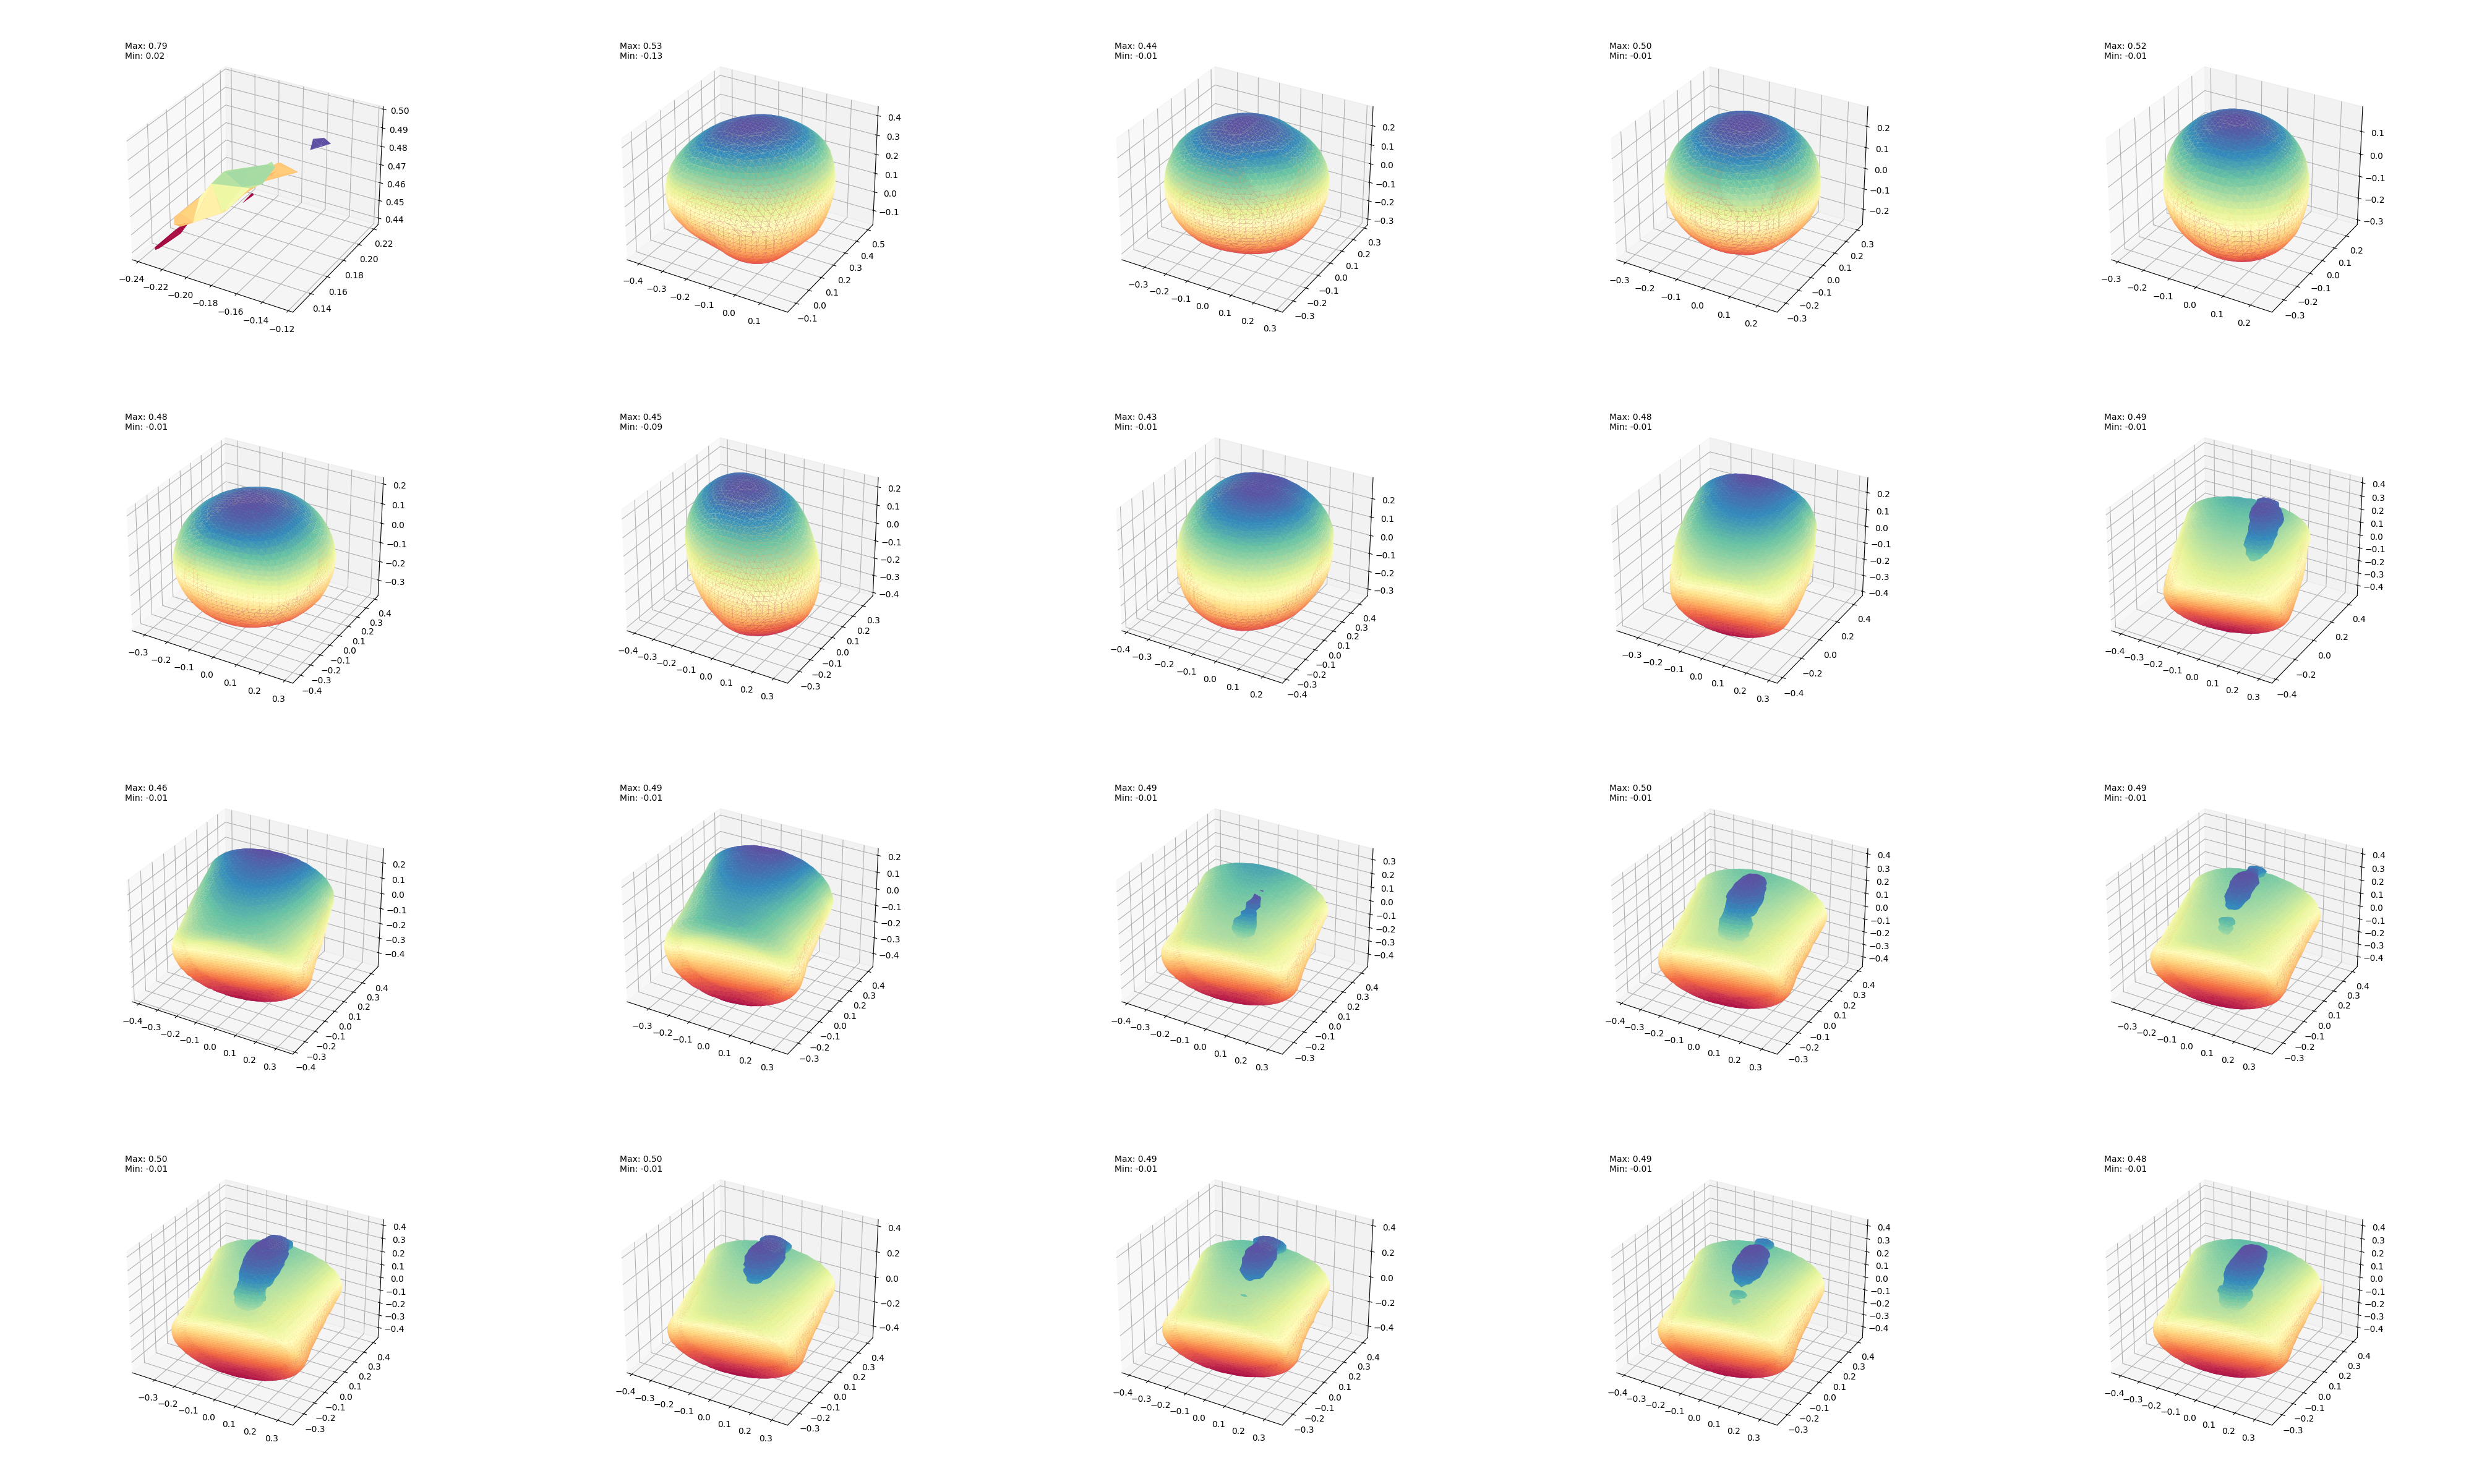

In [20]:
from viz_x import viz_x, viz_x_img

# viz_x(a, model, device)
single_images, combined_image = viz_x_img(a, model, device, train_ds.normal_params)
display(combined_image)

## Traj over time (x_t)

In [ ]:
time_slice = slice(990, 1001, 1)
sample_idx = 0

latent_x = np.stack(trajs[time_slice])[:,sample_idx,...]
latent_x = torch.from_numpy(latent_x)
latent_x.shape


In [ ]:
from viz_x import viz_x
viz_x(latent_x, model, device)


## simple viz

In [ ]:
from viz_x import viz_x
# viz_x(latent_x, model, device)

viz_x(torch.tensor(trajs[-1]), model, device, train_ds.normal_params)